# Generalized Standard Material Model API Demonstration

This notebook demonstrates the usage of the `GSMModel` class, which provides a bridge between 
symbolic material definitions (using `GSMDef`) and executable numerical models with concrete parameter values.

We'll use the elastic-damage model (`GSM1D_ED`) as an example to show how simple it is to create, parametrize, and 
visualize material responses using this framework.


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import traits.api as tr
import bmcs_utils.api as bu

# Import the GSM framework
from bmcs_matmod.gsm_lagrange.core.gsm_model import GSMModel

# Import the specific model we'll use for demonstration
from bmcs_matmod.gsm_lagrange.models.gsm1d_ed import GSM1D_ED

# For nicer plot display
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
try:
    plt.style.use('bmcs')
except:
    pass

# For LaTeX rendering in plots
plt.rcParams['text.usetex'] = False


## 1. Examining the Elastic-Damage Model

First, let's take a look at the `GSM1D_ED` class to understand its structure. This is a 1D elastic damage model implemented using the GSM framework.

In [ ]:
from bmcs_matmod.gsm_lagrange.core.gsm_def import GSMDef
from bmcs_matmod.gsm_lagrange.core.gsm_engine import GSMEngine
from bmcs_matmod.gsm_lagrange.core.gsm_vars import Scalar, Vector
import sympy as sp

In [5]:
E = Scalar(r'E', real=True, nonnegative=True)
eta_ve = Scalar(r'\eta_\mathrm{ve}', real=True, nonnegative=True, codename='eta_ve')

mparams = (E, eta_ve)


# ## External state variables

# eps = Scalar(r'\varepsilon', real=True, codename='eps')
# eps_a = Vector(r'\varepsilon_{a}', [eps])
eps_a = sp.MatrixSymbol(r'\varepsilon', 1, 1)
# sig = Scalar(r'\sigma', real=True, codename='sig')
# sig_a = Vector(r'\sigma_{a}', [sig])
sig_a = sp.MatrixSymbol(r'\sigma', 1, 1)

# ## Internal state variables

# eps_v = Scalar(r'\varepsilon^\mathrm{v}', real=True, codename='eps_v')
# eps_v_a = Vector(r'\varepsilon^\mathrm{v}_{a}', [eps_v], codename='eps_v_a')
eps_v_a = sp.MatrixSymbol(r'\varepsilon^\mathrm{v}', 1, 1)
# sig_v = Scalar(r'\sigma', real=True, codename='sig_v')
# sig_v_a = Vector(r'\sigma_{a}', [sig_v], codename='sig_v_a')
sig_v_a = sp.MatrixSymbol(r'\sigma^\mathrm{v}', 1, 1)

eps_el_a = eps_a - eps_v_a
U_e_a = sp.Rational(1,2) * E * eps_el_a.T * eps_el_a

# ## Free energy potential
# eps_el = eps - eps_v
# U_e_ = sp.Rational(1,2) * E * eps_el**2
F_ = U_e_a[0, 0]

Eps_vars = (eps_v_a,)
Sig_vars = (sig_v_a,)
Sig_signs =  (-1,)

F_engine = GSMEngine(
    name = 'gsm_F_1d_mpdp_ve',
    diff_along_rates = False,
    eps_vars = eps_a,
    sig_vars = sig_a,
    m_params = mparams,
    Eps_vars = Eps_vars,
    Sig_vars = Sig_vars,
    Sig_signs = Sig_signs,
    F_expr = F_,
)


In [6]:
F_engine.Eps

In [7]:
# dot_eps_ve_a = F_engine.dot_Eps[0, 0]

class GSM1D_ED
Helmholtz


<IPython.core.display.Math object>

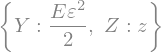

Gibbs


<IPython.core.display.Math object>

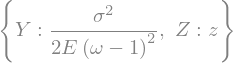

Mechanical dissipation


<IPython.core.display.Math object>

Lagrangian


<IPython.core.display.Math object>

Residuum


<IPython.core.display.Math object>

In [8]:
# Examine the GSM1D_ED class
gsm1d_ed = GSM1D_ED()
gsm1d_ed.print_potentials()

## 2. Creating a Material Model from GSM1D_ED

Now, let's use the `GSMModel` class to create an executable model with specific parameter values. The `GSMModel` class automatically:

1. Analyzes the symbolic model structure
2. Creates traits for all parameters  
3. Provides methods for numerical simulation

This allows us to work with material models in a more intuitive way, defining parameter values directly and running simulations without managing the symbolic-to-numerical conversion manually.


In [9]:
# Create a material model from the GSM1D_ED symbolic model
ed_material = GSMModel(GSM1D_ED)

# View the default parameters
print("Default parameters:")
for param_sym, name in ed_material.trait_model_params.items():
    value = getattr(ed_material, name)
    print(f"  {name} = {value} ({param_sym})")

print("\n" + "-"*50 + "\n")

# Set parameters to customize the model using set_params
ed_material.set_params(
    E=20000.0,    # Young's modulus (MPa)
    S=1,          # Damage threshold strain
    c=1,          # ratio
    eps_0=0.0     # Initial inelastic strain
)

# View the updated parameters
print("Updated parameters:")
for param_sym, name in ed_material.trait_model_params.items():
    value = getattr(ed_material, name)
    print(f"  {name} = {value} ({param_sym})")

print("\n" + "-"*50 + "\n")

Default parameters:
  E = 1.0 (E)
  S = 1.0 (S)
  c = 1.0 (c)
  r = 1.0 (r)
  eps_0 = 1.0 (\varepsilon_0)

--------------------------------------------------

Updated parameters:
  E = 20000.0 (E)
  S = 1.0 (S)
  c = 1.0 (c)
  r = 1.0 (r)
  eps_0 = 0.0 (\varepsilon_0)

--------------------------------------------------



## 3. Monotonic Tension Test

Let's simulate a monotonic tension test to see how our material behaves. This will demonstrate the strain-softening behavior characteristic of damage mechanics.

In [10]:
# Define a monotonic tensile strain history
n_steps = 1000
strain_max = 0.13  # Maximum strain
strain = np.linspace(0, strain_max, n_steps)
time = np.linspace(0, 1.0, n_steps)

# Run the simulation with our material model
# Using the standard get_F_response method which handles the correct parameter preparation
rd = ed_material.get_F_response(strain, time)

In [11]:
ed_material.gsm_def.Eps_codenames

{\omega: 'omega', z: 'z'}

In [12]:
rd.Eps_t.keys()

dict_keys(['omega_a', 'z_a'])

In [13]:
# Extract and reshape for easier plotting
eps = rd.eps_t[:, 0]
sig = rd.sig_t[:, 0]
omega = rd.Eps_t.omega_a[:, 0, 0]  # First internal variable (damage variable)

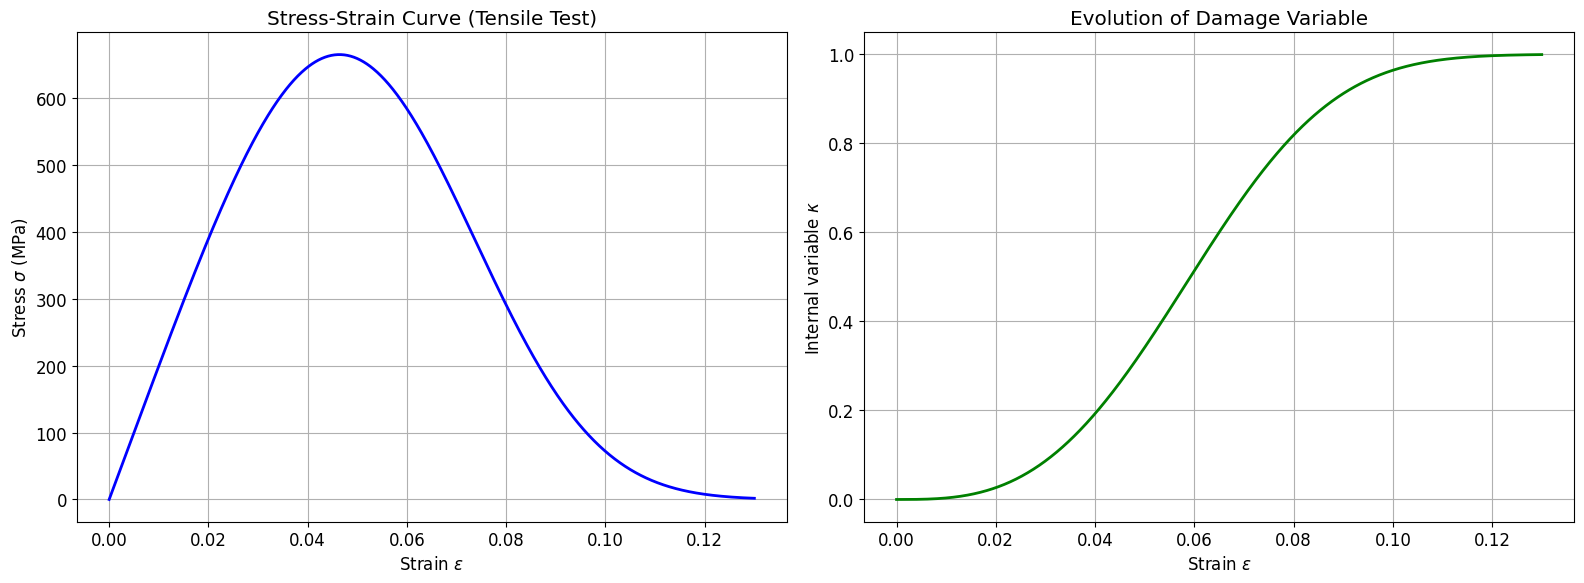

In [14]:
# Plot the stress-strain curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stress-strain curve
ax1.plot(eps, sig, 'b-', linewidth=2)
ax1.set_xlabel('Strain $\\varepsilon$')
ax1.set_ylabel('Stress $\\sigma$ (MPa)')
ax1.set_title('Stress-Strain Curve (Tensile Test)')
ax1.grid(True)

# Evolution of internal variable (kappa - damage)
ax2.plot(eps, omega, 'g-', linewidth=2)
ax2.set_xlabel('Strain $\\varepsilon$')
ax2.set_ylabel('Internal variable $\\kappa$')
ax2.set_title('Evolution of Damage Variable')
ax2.grid(True)

plt.tight_layout()

In [ ]:
from bmcs_matmod.gsm_lagrange.core.response_data_widget import ResponseDataWidget

# Create a widget with response data
widget = ResponseDataWidget(response_data=rd)

# Display the widget
widget.get_widget()